# Download the Cityscapes dataset

In [ ]:
# 1. Login (replace 'your_username' and 'your_password') (if you dont have then, create an account in cityscapes website.)
!wget --save-cookies cookies.txt \
     --keep-session-cookies \
     --post-data 'username=your_username&password=your_password&submit=Login' \
     https://www.cityscapes-dataset.com/login/


#  --post-data 'username=your_username&password=your_password&submit=Login' \
# 2. Download the required files
!wget --load-cookies cookies.txt \
     --content-disposition \
     https://www.cityscapes-dataset.com/file-handling/?packageID=3  # leftImg8bit_trainvaltest.zip
!wget --load-cookies cookies.txt \
     --content-disposition \
     https://www.cityscapes-dataset.com/file-handling/?packageID=1  # gtFine_trainvaltest.zip

In [ ]:
# !unzip "/content/drive/MyDrive/cityscapes/gtFine_trainvaltest.zip"
# !unzip "/content/drive/MyDrive/cityscapes/leftImg8bit_trainvaltest.zip"

In [ ]:
# Dataset is stored in the below drive link so create a shortcut of it into your drive and mount the drive to access the data from this notebook.
# https://drive.google.com/drive/folders/147H7-ueJ_I4k3hs632HRkYAvJuGRqwRQ?usp=drive_link

# Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Viewing Image and it's Mask

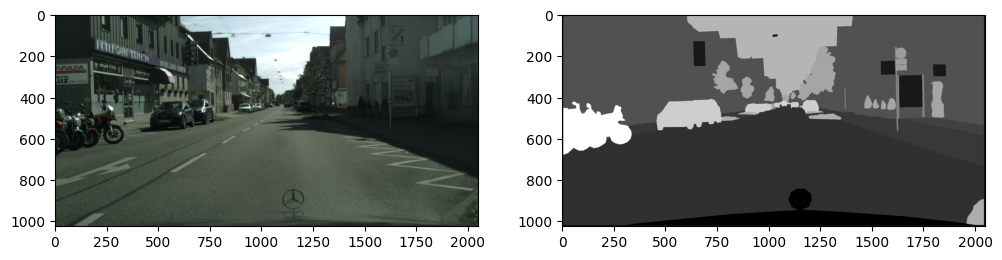

In [3]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
dataset = Cityscapes('/content/drive/MyDrive/cityscapes/', split='train', mode='fine',
                      target_type='semantic')
dataset[0][0].size
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

# Imports

In [4]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity as ssim  # For mAP-like metric


# **1. Dataset Setup (Modify Paths)**

In [6]:
dataset_path = '/content/drive/MyDrive/cityscapes'
leftImg8bit_dir = os.path.join(dataset_path, 'leftImg8bit/train')
gtFine_dir = os.path.join(dataset_path, 'gtFine/train')

# **2. Data Splitting**

In [ ]:
image_files = [f for f in os.listdir(leftImg8bit_dir) if f.endswith('.png')]
random.shuffle(image_files)
train_files = image_files[:3500]
test_files = image_files[3500:]

# **3. U-Net Model**

In [7]:
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    concat6 = concatenate([u6, c4])  # Skip connection
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(c6)
    return Model(inputs, outputs)

# **4. Data Generators**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=15,  # Random rotations for augmentation
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'  # How to fill in new pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization for the test set

# Flow from Directory (Adjusted)
train_generator = train_datagen.flow_from_directory(
    leftImg8bit_dir,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42)

test_generator = test_datagen.flow_from_directory(
    leftImg8bit_dir,  # Changes here too, depending on the test set structure
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

# **5. Model Setup**

In [ ]:
import tensorflow as tf

input_shape = (512, 512, 3)
num_classes = 34
model = unet_model(input_shape, num_classes)

def dice_loss(y_true, y_pred):
    smooth = 1.  # Smoothing factor for stability
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

def dice_coef(y_true, y_pred):
    return 1.0 - dice_loss(y_true, y_pred) # Since we want to maximize the DICE coefficient

def combined_loss(y_true, y_pred):
    nll_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    return nll_loss + dice_loss(y_true, y_pred)

model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', dice_coef])

# **6. Training**

In [ ]:
model.fit(train_generator, epochs=20, validation_data=test_generator)

# **7. Evaluation**

In [ ]:
test_loss, test_acc, test_dice = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test DICE Score:', test_dice)